# Desafío N° 1 - Data Wrangling

Esta notebook va a llevar a adelante el Desafío N° 1 del curso de DataScience sobre un dataset correspondiente a la web Properati donde se publican inmuebles de todo el país

In [1]:
# En primer lugar importamos las librerias con las que vamos a trabajar a lo largo del proyecto

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas
import geoplot as geo

In [2]:
# Es necesario importar el dataset con el cual vamos a trabajar

file_path = "properati.csv"
data = pd.read_csv(file_path, sep = ",")
print(data.shape)
data.head(2)

(121220, 26)


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.0,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...


In [3]:
data.dtypes.value_counts()

float64    13
object     12
int64       1
dtype: int64

Se observa que el dataset cuenta con 121000 observaciones y 26 variables, de las cuales 13 son numeros reales, 12 son strings y 1 es un entero (esta igual debemos removerla ya que se trata de un indice innecesario)

In [4]:
# Procedemos a remover la primer columna del dataset

data = data.iloc[:,1:]
data.head(2)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,...,40.0,1127.272727,1550.0,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...


In [5]:
# Algo interesante para mirar sería el tipo de dato que tiene cada variable

print(data.dtypes)
print("\n")

# Y también ver como se distribuyen los datos que son numericos
data.info()

operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: object


<class 'pandas.core.frame.DataFram

Se ve que hay algunas columnas que parecen no aportar mucha información al dataset, mas bien redundan basadas en otras columnas
En este sentido esto va en contra de la idea de "tidy data".
Sería una buena idea remover estas columnas

Por otro lado hay columnas muy poco relevantes como por ejemplo el URL de la publicación o el URL de las fotos presentes en el dataset. A simple vista se ve que esto no puede ser manejado por ningún modelo predictivo.
También seria relevanete remover estas columnas

In [6]:
data.drop(['place_with_parent_names', 'lat-lon'], axis = 1, inplace= True)
data.drop(['image_thumbnail'], axis = 1, inplace= True)

## Análisis sobre CABA

Dado que el dataset es sustancialemnte grande y con gran variabilidad en la completitud de los datos, decidimos enfocar nuestro análisis sobre una región en particular: Capital Federal, ya que es la región que aglomera la mayor cantidad de publicaciones

In [7]:
data.state_name.value_counts().head(4)

Capital Federal             32316
Bs.As. G.B.A. Zona Norte    25560
Bs.As. G.B.A. Zona Sur      13952
Córdoba                     12069
Name: state_name, dtype: int64

In [8]:
states = ["Capital Federal"]

mask = [(x in states) for x in data.state_name]

data_caba = data.loc[mask,:]
data_caba.sample(3)

,operation,property_type,place_name,country_name,state_name,geonames_id,lat,lon,price,currency,...,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title
87852,sell,apartment,Chacarita,Argentina,Capital Federal,3435506.0,NaN,NaN,105165.0,USD,...,51.0,48.0,2062.058824,2190.937500,NaN,NaN,NaN,http://www.properati.com.ar/1b6hz_venta_depart...,Entrega Marzo 2019Forma de pago 50% y 22 cuota...,"Venta al costo, lanzamiento posibilidad de fin..."
71782,sell,store,Palermo Hollywood,Argentina,Capital Federal,NaN,NaN,NaN,NaN,NaN,...,154.0,154.0,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/1alf9_venta_local_...,Se implanta sobre un lote de 30 m de frente so...,Local - Palermo Hollywood
96235,sell,apartment,Villa Crespo,Argentina,Capital Federal,3427458.0,NaN,NaN,107057.0,USD,...,34.0,31.0,3148.735294,3453.451613,NaN,NaN,1200.0,http://www.properati.com.ar/1bid1_venta_depart...,El edificio Serrano 629 cuenta con unidades de...,Departamento - Villa Crespo - hermoso ambiente


In [9]:
data_caba.shape

(32316, 22)

# Manejo preliminar de Outliers

### Superficie en m2

Una de las principales variables del dataset es la superficie de la propiedad ya que define en gran medida el precio final del inmueble. Es importante estudiar si existe algún tipo de outlier antes de empezar a trabajar sobre el dataset y realicemos imputaciones.

Se ve que hay un valor muy extremo que perjudica la dsitribución de los datos, la mejor decisión va a ser eliminar ese dato y llenarlo con null.

Por otro lado se ve que hay muchos departamentos con valores muy elevados de superficie cubierta y sin embargo las descripciones no coinciden con esos valores. En la mayor parte de los casos es el valor de la descripción multiplicado por 100 (un error de decimales)

[(0.0, 200000.0), Text(0, 0.5, 'Tipo Propiedad'), Text(0.5, 0, 'Sup Cubierta')]

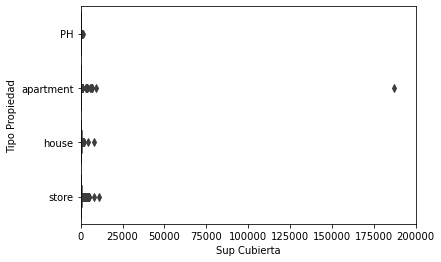

In [10]:
g = sns.boxplot(x = data_caba.surface_covered_in_m2, y = data_caba.property_type)
g.set(xlim=(0,200000), ylabel = "Tipo Propiedad", xlabel = "Sup Cubierta")

In [11]:
# Superfice cubierta en m2

maximo = data_caba.surface_covered_in_m2.max()
data_caba['surface_covered_in_m2'] = data_caba.surface_covered_in_m2.replace(maximo, np.NaN)

remplazo = data_caba[(data_caba.property_type == 'apartment') & (data_caba.surface_covered_in_m2 > 1000)].surface_covered_in_m2 / 100

prueba = pd.merge(data_caba, remplazo, right_index= True, left_index= True, suffixes=("","_new"), how = 'left')
prueba

data_caba['surface_covered_in_m2'] = prueba.surface_covered_in_m2_new.fillna(prueba.surface_covered_in_m2)

C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


[(0.0, 8000.0), Text(0, 0.5, 'Tipo Propiedad'), Text(0.5, 0, 'Sup Cubierta')]

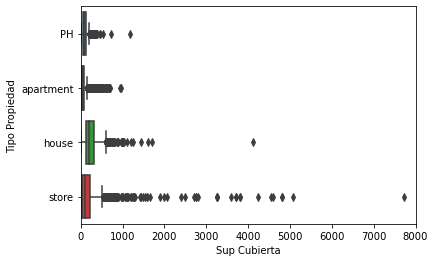

In [12]:
g = sns.boxplot(x = data_caba.surface_covered_in_m2, y = data_caba.property_type)
g.set(xlim=(0,8000), ylabel = "Tipo Propiedad", xlabel = "Sup Cubierta")

C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


<AxesSubplot:xlabel='surface_total_in_m2', ylabel='property_type'>

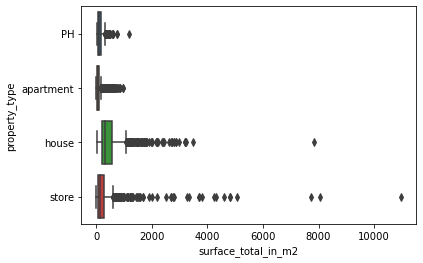

In [13]:
maximo = data_caba.surface_total_in_m2.max()
data_caba['surface_total_in_m2'] = data_caba.surface_total_in_m2.replace(maximo, np.NaN)

remplazo = data_caba[(data_caba.property_type == 'apartment') & (data_caba.surface_total_in_m2 > 1000)].surface_total_in_m2 / 100

prueba = pd.merge(data_caba, remplazo, right_index= True, left_index= True, suffixes=("","_new"), how = 'left')
prueba

data_caba['surface_total_in_m2'] = prueba.surface_total_in_m2_new.fillna(prueba.surface_total_in_m2)

sns.boxplot(data_caba.surface_total_in_m2, data_caba.property_type)

Otro aspecto que nos resultó extraño es la presencia de relaciones muy elevadas entre la superficie cubierta y la total, especialmente en el caso de los "apartments" y los "PH". Al analizarlo en detalle descubrimos que en algunos casos se trata de errores en la carga y procedemos a ajustar sus valores

<AxesSubplot:ylabel='property_type'>

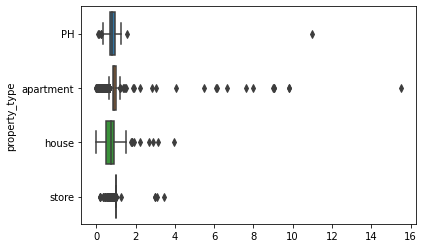

In [14]:
por_sup_cubierta = data_caba.surface_covered_in_m2/data_caba.surface_total_in_m2
por_sup_cubierta.describe()

sns.boxplot(x = por_sup_cubierta, y = data_caba.property_type)

C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


<AxesSubplot:ylabel='property_type'>

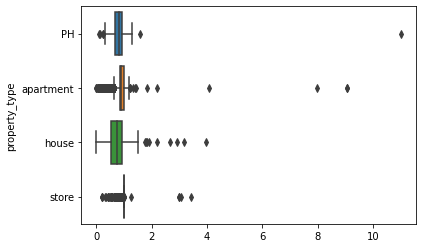

In [15]:
dat = data_caba

ind = dat[(por_sup_cubierta > 1.5) & (dat.property_type == "apartment") & (dat.price_usd_per_m2 > 5000)].index

dat.loc[ind,'surface_total_in_m2'] = dat.loc[ind,'surface_covered_in_m2']


por_sup_cubierta = dat.surface_covered_in_m2/dat.surface_total_in_m2
sns.boxplot(x = por_sup_cubierta, y = dat.property_type)

In [16]:
maximo_PH = dat[(dat.property_type == "PH") & (por_sup_cubierta > 2)].surface_covered_in_m2
ind = dat[(dat.property_type == "PH") & (por_sup_cubierta > 2)].index

dat.loc[ind, 'surface_total_in_m2'] = maximo_PH

C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [17]:
data_caba = dat

### Precio y precio x m2

Estas dos variables también son muy relevantes ya que son las que queremos predecir o estimar en un futuro. Intentar eliminar los valores extraños o ruidosos podría ayudarnos a obtener mejores resultados

No es tan conveniente trabajar sobre los precios ya que dependen del tamaño de la propiedad, pero por otro lado el precio por m2 es una metrica más estable y que deberíamos analizar que no tenga valores extremos

In [18]:
ind = data_caba[(data_caba.price_usd_per_m2 > 20000) & ((data_caba.property_type == "apartment") | (data_caba.property_type == "PH"))].index

data_caba.loc[ind, 'price_usd_per_m2'] = np.NaN

<AxesSubplot:>

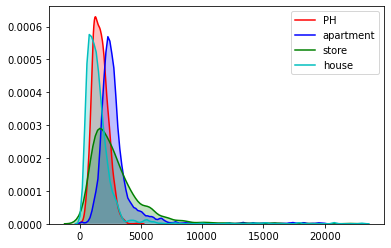

In [19]:
PH = data_caba[data_caba.property_type =="PH"].price_usd_per_m2
PH.name = "PH"

apartment = data_caba[data_caba.property_type =="apartment"].price_usd_per_m2
apartment.name = "apartment"

store = data_caba[data_caba.property_type =="store"].price_usd_per_m2
store.name = "store"

house = data_caba[data_caba.property_type =="house"].price_usd_per_m2
house.name = "house"

sns.kdeplot(PH, shade = True, color = "r")
sns.kdeplot(apartment, shade = True, color = "b")
sns.kdeplot(store, shade = True, color = "g")
sns.kdeplot(house, shade = True, color = "c")

<AxesSubplot:xlabel='price_usd_per_m2', ylabel='property_type'>

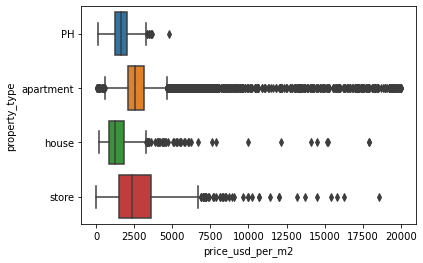

In [20]:
data_2 = data_caba
data_2 = data_2[data_2.price_usd_per_m2 < 20000]
sns.boxplot(y = data_2.property_type, x = data_2.price_usd_per_m2)

C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


<AxesSubplot:>

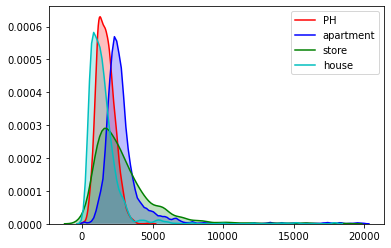

In [21]:
PH = data_2[data_caba.property_type =="PH"].price_usd_per_m2
PH.name = "PH"

apartment = data_2[data_caba.property_type =="apartment"].price_usd_per_m2
apartment.name = "apartment"

store = data_2[data_caba.property_type =="store"].price_usd_per_m2
store.name = "store"

house = data_2[data_caba.property_type =="house"].price_usd_per_m2
house.name = "house"

sns.kdeplot(PH, shade = True, color = "r")
sns.kdeplot(apartment, shade = True, color = "b")
sns.kdeplot(store, shade = True, color = "g")
sns.kdeplot(house, shade = True, color = "c")

## EDA - Missing Data

Un análisis que es importante realizar es la presencia de datos faltantes que tiene el dataset.
A simple vista se ve que muchas de las variables numércias tienen varios valores faltantes, es necesario identificar que % de la data representa y si sería posible tomar una decisión de imputación.

Viendo los resultados mostrados en el gráfico, se puede observar que hay algunas variables con un importante % de valore faltantes (superiores al 50% de los datos - "floor", "expensas", "rooms"). En principio generar algún método de imputación parece ser muy complejo. Contamos tanto con la descripción de la publicación y con el título de la misma, por lo que se podría implementar un método regex para extraer estos datos

Con el resto de las variables numéricas podría intentar realziarse una imputación:
1. lon, lat: en estas variables no tiene tanto sentido ya que dependen mucho de la ubicación del inmueble y solo contambos con el barrio/ciudad. En caso de querer imputarlas podrían manejarse dos opciones
        1.a. poner la lon, lat que sale del barrio en Google Maps
        1.b. buscar en las descripciones los nombres de las calles o la dirección y con API de GoogleMaps extraer lon, lat
        1.c. utilizar el dato de geonames para extraer la lat-lon y en los casos que falta completar con el promedio del barrio
2. price_USD_per_m2: esto no es más que un cálculo en base a otras variables que también tienen datos faltantes, de ser posible estimar las anteriores de podría completar en su totalidad
3. El resto de las variables con algunos de los mecanismos de imputación podrían resolverse

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, 'floor'),
  Text(0, 1, 'expenses'),
  Text(0, 2, 'rooms'),
  Text(0, 3, 'price_usd_per_m2'),
  Text(0, 4, 'lat'),
  Text(0, 5, 'lon'),
  Text(0, 6, 'surface_total_in_m2'),
  Text(0, 7, 'price_per_m2'),
  Text(0, 8, 'price_aprox_local_currency'),
  Text(0, 9, 'currency'),
  Text(0, 10, 'price_aprox_usd'),
  Text(0, 11, 'price'),
  Text(0, 12, 'surface_covered_in_m2'),
  Text(0, 13, 'geonames_id'),
  Text(0, 14, 'place_name'),
  Text(0, 15, 'country_name'),
  Text(0, 16, 'property_type'),
  Text(0, 17, 'title'),
  Text(0, 18, 'state_name'),
  Text(0, 19, 'description'),
  Text(0, 20, 'properati_url'),
  Text(0, 21, 'operation')])

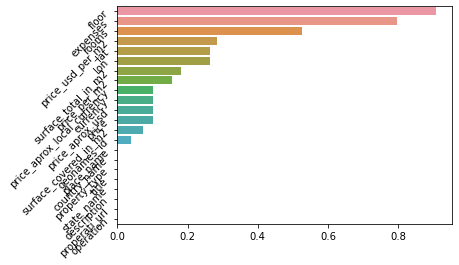

In [22]:
missing_data = data_caba.isnull().sum(axis = 0) / data_caba.shape[0]
missing_data.sort_values(inplace = True, ascending = False)
miss = missing_data

g = sns.barplot(y = miss.index, x = miss)
plt.yticks(rotation = 45)

In [23]:
miss

floor                         0.906888
expenses                      0.796014
rooms                         0.525777
price_usd_per_m2              0.284905
lat                           0.264451
lon                           0.264451
surface_total_in_m2           0.181953
price_per_m2                  0.154475
price_aprox_local_currency    0.102055
currency                      0.102055
price_aprox_usd               0.102055
price                         0.102055
surface_covered_in_m2         0.072410
geonames_id                   0.039795
place_name                    0.000000
country_name                  0.000000
property_type                 0.000000
title                         0.000000
state_name                    0.000000
description                   0.000000
properati_url                 0.000000
operation                     0.000000
dtype: float64

En lineas generales Capital Federal y Bs.As. G.B.A. Zona Norte son las dos regiones que tienen menor cantidad de datos faltantes en cada una de las categorías de datos más importnates (precio, superficie, ambientes)

In [24]:
a = data.surface_covered_in_m2.isnull().groupby(data['state_name']).sum().sort_values(ascending = False)
b = pd.merge(a, data.state_name.value_counts(), left_index=True, right_index = True)
b["porcentaje_null"] = b.surface_covered_in_m2/b.state_name
b.porcentaje_null.sort_values().head()

Santiago Del Estero         0.000000
Bs.As. G.B.A. Zona Norte    0.069327
Capital Federal             0.072379
Corrientes                  0.125214
Bs.As. G.B.A. Zona Oeste    0.148251
Name: porcentaje_null, dtype: float64

## Adaptación de nombres

Para poder manejarnos más facil vamos a adaptar los nombres de las columnas

In [25]:
data_caba.columns
data_caba.columns = ['operacion', 'tipo_prop', 'barrio', 'pais', 'provincia', 'geoname', 'lat', 'lon', 
                 'precio', 'moneda', 'precio_pesos', 'precio_usd', 'sup_total', 'sup_cubierta', 'precio_usd_m2', 'precio_m2',
                'piso', 'ambientes', 'expensas','properati_url', 'descripcion', 'titulo']

data_caba.columns

Index(['operacion', 'tipo_prop', 'barrio', 'pais', 'provincia', 'geoname',
       'lat', 'lon', 'precio', 'moneda', 'precio_pesos', 'precio_usd',
       'sup_total', 'sup_cubierta', 'precio_usd_m2', 'precio_m2', 'piso',
       'ambientes', 'expensas', 'properati_url', 'descripcion', 'titulo'],
      dtype='object')

## Análisis del contenido de descripción y título

### Ambientes

In [26]:
# Con el metodo extract se puede ubicar el primer elemento de la cadena de texto que cumple la condición planteada
# En algunos casos, en la descripción aparecen menciones amuchos tipos de dptos ya que suelen ser desarrollos inmobiliarios
# Por eso priorizamos el dato que viene del titulo y si este no tiene, completamos con el primer dato de la descripcion

a = data_caba.descripcion.str.extract("(?P<amb>\d{1,2})\s*amb|(?P<mono>mono)\S*amb", flags = re.IGNORECASE)

a['mono'] = a.mono.replace(re.compile("mono", flags = re.IGNORECASE), "1")

a['ambientes'] = a.amb.fillna(a.mono).astype(float)



b = data_caba.descripcion.str.extract("(?P<amb>\d{1,2})\s*amb|(?P<mono>mono)\S*amb", flags = re.IGNORECASE)

b['mono'] = b.mono.replace(re.compile("mono", flags = re.IGNORECASE), "1")

b['ambientes'] = b.amb.fillna(b.mono).astype(float)



ambientes = b.ambientes.fillna(a.ambientes)

ambientes

0         2.0
2         2.0
3         3.0
7         1.0
8         NaN
         ... 
121160    NaN
121209    NaN
121215    NaN
121217    1.0
121219    NaN
Name: ambientes, Length: 32316, dtype: float64

In [27]:
data_ambientes = data_caba.join(ambientes, rsuffix="_nuevo")

data_ambientes['ambientes2'] = data_ambientes.ambientes_nuevo.fillna(data_ambientes.ambientes)
print(data_ambientes.ambientes2.isnull().sum())
data_ambientes.loc[:,['ambientes', 'ambientes_nuevo', 'ambientes2']].sample(10)

7604


,ambientes,ambientes_nuevo,ambientes2
49194,3.0,NaN,3.0
79146,NaN,1.0,1.0
74484,NaN,3.0,3.0
75277,NaN,NaN,NaN
93407,NaN,4.0,4.0
25337,2.0,2.0,2.0
112230,NaN,NaN,NaN
69149,NaN,2.0,2.0
14009,NaN,NaN,NaN
73609,NaN,2.0,2.0


In [28]:
data = data_ambientes.drop(['ambientes', 'ambientes_nuevo'], axis = 1)
data = data.rename(columns = {'ambientes2': 'ambientes'})

### Piso del dpto

In [29]:
pisos = data.descripcion.str.extract("(\d)\s*er|(\d{1,2})\s*\wo|(\d)°|\s+(PB)\s+|(\w{5,10})\s+piso", flags = re.IGNORECASE)

pisos.iloc[:,3].value_counts()

pisos.iloc[:,3] = pisos.iloc[:,3].apply(lambda x: x if x is np.NaN else "0")

pisos.iloc[:,3].value_counts()

pisos['piso'] = pisos.iloc[:,0].fillna(pisos.iloc[:,1])
pisos['piso'] = pisos.piso.fillna(pisos.iloc[:,2])
pisos['piso'] = pisos.piso.fillna(pisos.iloc[:,3])

pisos.piso.value_counts()

2     4050
3     1676
1     1372
4      908
0      616
      ... 
88       1
59       1
46       1
68       1
89       1
Name: piso, Length: 103, dtype: int64

In [30]:
indice = ['primer', 'segundo', ' tercer', 'cuarto', 'quinto', 'sexto', 'ptimo', 'octavo', 'noveno']
numero = [1,2,3,4,5,6,7,8,9]

c = pd.Series()

for pis,numero in zip(indice,numero):
    a = pisos.iloc[:,4].str.contains(pis, flags = re.IGNORECASE)
    b = a.apply(lambda x: numero if x is True else np.NaN)
    c = c.fillna(b)

pisos['piso'] = pisos.piso.fillna(c)
pisos['piso'] = pisos.piso.astype(float)

C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='piso'>

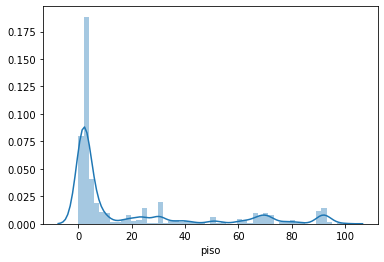

In [31]:
sns.distplot(pisos.piso)

In [32]:
data['piso'] = data.piso.fillna(pisos.piso)

### Precios en USD

In [33]:
mascara = (data.precio_usd < 75000) & ((data.precio < 1000000) | (data.precio_usd_m2 < 1000))

a = data[mascara].precio
b = data[[not x for x in mascara]].precio_usd
a = a.append(b)

data['precio_usd'] = a

data['precio_usd'][data.precio_usd < 30000] = np.NaN

data.precio_usd.isnull().sum()

C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


3329

In [35]:
#Extraccion desde Title
desc5 = re.compile("\s*(?P<preciousd>(U\$D\s*\d*([.]\d*){1,2})|(U\$S\s*\d*([.]\d*){1,2}))" , flags =  re.IGNORECASE)
usd_title_s = data.titulo.apply(lambda x:  re.search(desc5, x))
usd_title = usd_title_s.apply(lambda x: x if x is None else x.group("preciousd"))


desc6 = re.compile("\d*[.]\d*")
p_usd2a = usd_title.apply(lambda x: np.NaN if x is None  else re.search(desc6, x)[0])
p_usd2 = p_usd2a.apply(lambda x: x if x is np.NaN else re.sub("[.]", "", x))
p_usd2 = p_usd2[p_usd2.notna()].astype(int)


p_usd2

108       170000
110       490000
115       440000
119       320000
120       178000
           ...  
119384    160000
119386    160000
119388    160000
119389    160000
119390    160000
Name: titulo, Length: 1133, dtype: int32

In [36]:
#Extraccion desde Descripcion
desc7 = re.compile("\s*(?P<preciousd>(U\$D\s*\d*([.]\d*){1,2})|(U\$S\s*\d*([.]\d*){1,2}))" , flags =  re.IGNORECASE)
usd_desc_s = data.descripcion.apply(lambda x: re.search(desc7, x))
usd_desc = usd_desc_s.apply(lambda x: x if x is None else x.group("preciousd"))


desc8 = re.compile("\d*[.]\d*")
p_usd1a = usd_desc.apply(lambda x: np.NaN if x is None  else re.search(desc8, x)[0])
p_usd1 = p_usd1a.apply(lambda x: x if x is np.NaN else re.sub("[.]", "", x))


p_usd = p_usd1.fillna(p_usd2)


p_usd.notnull().sum()

3211

In [37]:
p_usd = pd.to_numeric(p_usd, errors= 'coerce')
p_usd

0        NaN
2        NaN
3        NaN
7        NaN
8        NaN
          ..
121160   NaN
121209   NaN
121215   NaN
121217   NaN
121219   NaN
Name: descripcion, Length: 32316, dtype: float64

In [38]:
data['precio_usd'] = data.precio_usd.fillna(p_usd)

## ¿Qué pasa con las variables numéricas?

Aca hay algunas variables basntante importantes para predecir el precio (suponiendo que ese es el objetivo final). Tomamos una serie de decisiones:
1. Se ve que cuando una propiedad no tiene datos en la columna "precio", tampoco presenta ningún dato relacionado con el mismo. En este caso se deberá analizar la imputación para los casos que tengan algún dato de superficie (total o cubierta) en base al barrio, el tipo de propiedad y el precio_promedio_barrio_propiedad

2. La columna de "precio_m2" lo unico que mira es el precio publicado dividido por la sup cubierta (precio/sup_cubierta). Esto no es muy consistente ya que mezcla tipos de monedas. De ser posible lo ideal va a ser eliminarla

3. Dentro de la parte que hace referenia a la superficie de las propiedades, hay mucha info faltante referida tanto a la superficie total como a la cubierta. Generalemnte la relación entre ambas tiene que ver con el tipo de propiedad y la zona (los dptos en Recoleta no suelen tener balcones y x lo tanto la sup total es parecida a la cubierta, mientras que un PH en Villa Urquiza puede tener un patio más grande). Imputamos el dato que falta (sea el total o el cubierto) en base a lo anterior


### 1. Precios - Conversión USD/$

Se puede tomar como TC promedio 17,76 ya que es el valor que se usa en todo el dataset

<AxesSubplot:xlabel='TC'>

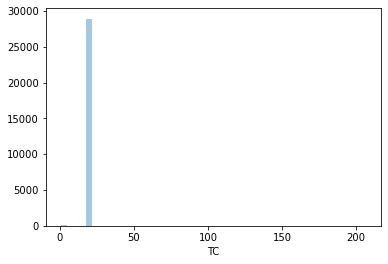

In [40]:
data['TC'] = data.precio_pesos / data.precio_usd

data.loc[:,['precio', 'precio_usd', 'precio_pesos', 'TC']].describe()

sns.distplot(data['TC'], kde= False)

In [41]:
# Todos los valores que no tienen precio, tampoco tienen ningun dato en las columnas de precio y precio_usd, salvo en los casos que logramos imputar

print(data[(data.precio.isnull()) & (data.precio_usd.isnull())].shape[0])
print(data[data.precio.isnull()].shape[0])

2933
3298


### 2. Lat y lon

In [42]:
# importamos el achivo
data_location = "AR.txt"
datageo = pd.read_csv(data_location,  sep='\t', header= None)

datageo = datageo.loc[:,[0,4,5]]

datageo.columns = ['geonameid', 'latitude', 'longitude']

datageo['geonameid'] = datageo.geonameid.astype(float)

In [43]:
data = pd.merge(data, datageo, how = "left", left_on = "geoname", right_on = "geonameid")

data['lat'] = data["lat"].fillna(data.latitude) 
data['lon'] = data["lon"].fillna(data.longitude)

In [44]:
# Completamos con el promedio de cada barrio. Otra opción podría haber sido utilziar el baricentro del barrio, pero no tenía ganas de buscarlo

lat_prom = data.groupby('barrio')['lat'].transform(lambda x: x.mean())
lon_prom = data.groupby('barrio')['lon'].transform(lambda x: x.mean())

data['lat'] = data.lat.fillna(lat_prom)
data['lon'] = data.lon.fillna(lon_prom)

### 3. Análisis sobre la superficie de los inmuebles

,lat,lon,precio,moneda,precio_pesos,precio_usd,sup_total,sup_cubierta,precio_usd_m2,precio_m2,piso,expensas,properati_url,descripcion,titulo,ambientes,TC,geonameid,latitude,longitude
3612,-34.622640,-58.441040,98000.0,USD,1729161.0,98000.0,32.0,NaN,3062.500000,NaN,10.0,NaN,http://www.properati.com.ar/16xq3_venta_depart...,"Caballito, excelente zona. Edificio construido...","Departamento 32m² con Plantas en Alberdi, Juan...",1.0,17.6445,3435874.0,-34.62264,-58.44104
3949,-34.639363,-58.505593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/171oz_venta_depart...,CODIGO: 1019-V309 ubicado en: RAMON L FALCON 5...,"2 AMBIENTES AL FRENTE , SOBRE BOULEVARD RAMON ...",2.0,NaN,3427407.0,-34.63814,-58.50273
17982,-34.642868,-58.437660,NaN,NaN,NaN,NaN,115.0,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/1ahf5_venta_depart...,AVISO LEGAL: Las descripciones arquitectónicas...,Departamento en P.Chacabuco,NaN,NaN,3433955.0,-34.60000,-58.45000
29498,-34.587950,-58.395243,88000.0,USD,1552716.0,88000.0,26.0,NaN,3384.615385,NaN,NaN,1100.0,http://www.properati.com.ar/1c6vw_venta_depart...,Barrio Norte RECOLETA A Mts.Avenida Pueyrredon...,Departamento - Recoleta,1.0,17.6445,3429595.0,-34.58870,-58.39723
30695,-34.549550,-58.466840,292000.0,USD,5152194.0,292000.0,110.0,NaN,2654.545455,NaN,NaN,NaN,http://www.properati.com.ar/1cdoo_venta_depart...,En una ubicación privi...,Departamento - Nuñez,NaN,17.6445,3430348.0,-34.54955,-58.46684
18137,-34.549550,-58.466840,2000000.0,USD,35289000.0,2000000.0,296.0,NaN,6756.756757,NaN,4.0,30000.0,http://www.properati.com.ar/1aih4_venta_depart...,"Torre Chateau Libertador, 4 dormitorios en su...",VENTA ESQUINERO UNICO EN TORRE CHATEAU LIBERTADOR,NaN,17.6445,3430348.0,-34.54955,-58.46684
13314,-34.600000,-58.450000,130000.0,USD,2293785.0,130000.0,NaN,NaN,NaN,NaN,3.0,NaN,http://www.properati.com.ar/19e98_venta_depart...,Ref.: 64Se vende departamento en la Cuidad de ...,Se vende departamento en la Cuidad de Azul,NaN,17.6445,3433955.0,-34.60000,-58.45000
26682,-34.642703,-58.511789,135000.0,USD,2382007.5,135000.0,70.0,NaN,1928.571429,NaN,NaN,NaN,http://www.properati.com.ar/1bleb_venta_depart...,"Departamento 70m² con Cloaca en Fonrouge 400, ...",Departamento en Liniers,NaN,17.6445,3431333.0,-34.64286,-58.52386
29562,-34.611017,-58.401453,120000.0,USD,2117340.0,120000.0,66.0,NaN,1818.181818,NaN,2.0,NaN,http://www.properati.com.ar/1c764_venta_ph_bal...,"Excelente PH 2 ambientes SIN EXPENSAS , con 2 ...",Balvanera - PH SIN EXPENSAS 2 ambientes en venta,2.0,17.6445,6693228.0,-34.61032,-58.39766
31384,-34.562700,-58.458290,95000.0,USD,1676227.5,95000.0,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/1cg5l_venta_depart...,"Departamento, Capital Federal, Belgrano, por U...",Departamento - Belgrano,NaN,17.6445,3436077.0,-34.56270,-58.45829


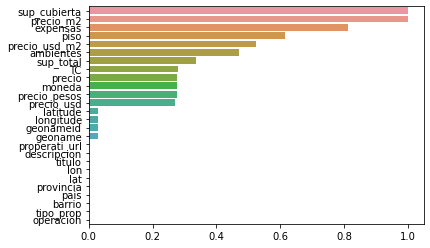

In [45]:
miss = data[data.sup_cubierta.isnull()].isnull().sum() / data[data.sup_cubierta.isnull()].shape[0]
miss.sort_values(ascending=False, inplace = True)

sns.barplot(y = miss.index, x= miss)

data[data.sup_cubierta.isnull()].sample(10).iloc[:,6:]

In [46]:
data['prueba'] = data.sup_cubierta/data.sup_total
data.groupby(['tipo_prop', 'barrio'])['sup_total'].mean()

data['prueba2'] = data.groupby(['tipo_prop', 'barrio'])['prueba'].transform(lambda x: x.mean())
data['sup_total_2'] = data.sup_total.fillna(data.sup_cubierta / data.prueba2)
data['sup_cubierta_2'] = data.sup_cubierta.fillna(data.sup_total * data.prueba2)


print(data.sup_total_2.isnull().sum())
print(data.sup_cubierta_2.isnull().sum())
data.loc[:,['tipo_prop', 'barrio', 'sup_total', 'sup_cubierta', 'sup_total_2', 'sup_cubierta_2']]

792
788


,tipo_prop,barrio,sup_total,sup_cubierta,sup_total_2,sup_cubierta_2
0,PH,Mataderos,55.0,40.0,55.0,40.000000
1,apartment,Mataderos,55.0,55.0,55.0,55.000000
2,PH,Liniers,NaN,NaN,NaN,NaN
3,apartment,Belgrano,45.0,40.0,45.0,40.000000
4,apartment,Belgrano,65.0,60.0,65.0,60.000000
...,...,...,...,...,...,...
32311,apartment,Belgrano,157.0,NaN,157.0,137.749789
32312,apartment,Belgrano,157.0,NaN,157.0,137.749789
32313,apartment,Belgrano,113.0,93.0,113.0,93.000000
32314,apartment,Villa Urquiza,46.0,39.0,46.0,39.000000


In [47]:
data = data.drop(['sup_total', 'sup_cubierta'], axis = 1)
data = data.rename({'sup_total_2': 'sup_total', 'sup_cubierta_2': 'sup_cubierta'}, axis = 1)

### 4. Análisis sobre los precio por m2

In [48]:
data['precio_x_m2_usd'] = data.precio_usd / data.sup_total

In [49]:
data['precio_usd'] = data.precio_usd.fillna(data.sup_total * data.precio_x_m2_usd)

### 5. Dataset limpio

In [50]:
data.columns

data = data.drop(['operacion', 'provincia', 'geoname', 'precio', 'moneda', 'precio_pesos', 
           'precio_usd_m2', 'precio_m2', 'expensas', 'descripcion', 'titulo', 'TC', 
           'prueba', 'prueba2', 'geonameid', 'latitude', 'longitude'], axis = 1)

In [51]:
data.sample(3)

,tipo_prop,barrio,pais,lat,lon,precio_usd,piso,properati_url,ambientes,sup_total,sup_cubierta,precio_x_m2_usd
25198,apartment,Almagro,Argentina,-34.609667,-58.41854,118000.0,NaN,http://www.properati.com.ar/1bbpn_venta_depart...,2.0,58.0,52.109884,2034.482759
30696,apartment,Nuñez,Argentina,-34.549550,-58.46684,159000.0,NaN,http://www.properati.com.ar/1cdop_venta_depart...,NaN,57.0,51.000000,2789.473684
19780,apartment,Capital Federal,Argentina,-34.600000,-58.45000,1000960.0,NaN,http://www.properati.com.ar/1aof7_venta_depart...,NaN,156.0,146.000000,6416.410256


# ANEXO I: Imputer from sklearn library

Funciona bien para algunas variables que son numéricas. Es neceasrio pasar todos lso datos categóricos a numéricos para que los tome

In [ ]:
data['tipo_prop'] = data.tipo_prop.astype('category')
data['barrio'] = data.barrio.astype('category')
data['moneda'] = data.moneda.astype('category')

probamos = data.drop(['operacion', 'pais', 'descripcion', 'titulo', 'provicnia'], axis = 1)

probamos['tipo_prop'] = probamos.tipo_prop.cat.codes
probamos['barrio'] = probamos.barrio.cat.codes
probamos['moneda'] = probamos.moneda.cat.codes

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=50, random_state=0)

imp.fit(probamos)

veamos = pd.DataFrame(imp.transform(probamos))

veamos.columns = probamos.columns
veamos.index = probamos.index
veamos['barrio'] = data.barrio
veamos['moneda'] = data.moneda
veamos['tipo_prop'] = data.tipo_prop
veamos

## ANEXO II: Incorporar data de transporte público

In [52]:
subte = pd.read_csv('estaciones-de-subte.csv')
subte.head(2)

,long,lat,id,estacion,linea
0,-58.398928,-34.635750,1.0,CASEROS,H
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H


In [53]:
lista = []

for i in data.index:
    
    dist_lat = (subte.lat - data.lat[i]) * 111000
    dist_lon = (subte.long - data.lon[i]) * 111000
    norma = (dist_lat ** 2 + dist_lon ** 2) ** (1/2)
    
    cantidad_subte = len(norma[norma < 500])
    
    lista.append(cantidad_subte)

cantidad_subte = pd.Series(lista, index = data.index, name = 'subtes')

data = data.join(cantidad_subte)

In [54]:
bicis = pd.read_csv('estaciones_sistema_viejo.csv')
bicis.head(2)

,id_estacion,nombre_estacion,long_estacion,lat_estacion,domicilio_estacion,tipo_estacion,observaciones,horario_estacion
0,1.0,Facultad de Derecho,-58.392452,-34.583133,Av. Pres.Figueroa Alcorta y Juan A.Bibiloni,AUTOMÁTICA,Abril 2015 (pasó de ser Manual a Automática),Estación automática: disponibilidad las 24 horas
1,2.0,Retiro,-58.374822,-34.592589,Av. Dr.Jose Ramos Mejia y Del Libertador Av,AUTOMÁTICA,Abril 2015 (pasó de ser Manual a Automática),Estación automática: disponibilidad las 24 horas


In [55]:
lista = []

for i in data.index:
    
    dist_lat = (bicis.lat_estacion - data.lat[i]) * 111000
    dist_lon = (bicis.long_estacion - data.lon[i]) * 111000
    norma = (dist_lat ** 2 + dist_lon ** 2) ** (1/2)
    
    cantidad_bicis = len(norma[norma < 500])
    
    lista.append(cantidad_bicis)

cantidad_bicis = pd.Series(lista, index = data.index, name = 'bicis')

data = data.join(cantidad_bicis)

## ANEXO III: Incorporar data de Seguridad

In [56]:
comisarias = pd.read_csv('comisarias-policia-de-la-ciudad.csv')
comisarias.head(2)

,long,lat,id,nombre,calle,altura,calle2,direccion,telefonos,observaciones,observaciones_2,barrio,comuna,codigo_postal,codigo_postal_argentino
0,-58.373245,-34.601906,1,Comisaria Vecinal 1-D,Lavalle,451,NaN,LAVALLE 451,4322-8033/8221,NaN,NaN,SAN NICOLAS,1,1047.0,C1047AAI
1,-58.424926,-34.628641,37,Comisaria Vecinal 5-B,Muñiz,1250,NaN,MUÑIZ 1250,4922-1229 /4922-3333,NaN,NaN,BOEDO,5,1255.0,C1255ACD


In [57]:
lista = []

for i in data.index:
    
    dist_lat = (comisarias.lat - data.lat[i]) * 111000
    dist_lon = (comisarias.long - data.lon[i]) * 111000
    norma = (dist_lat ** 2 + dist_lon ** 2) ** (1/2)
    
    comisaria_dist_min = min(norma)
    
    lista.append(comisaria_dist_min)

comisaria_mas_cerca = pd.Series(lista, index = data.index, name = 'comisarias')

data = data.join(comisaria_mas_cerca)

# ¿Cómo quedó el dataset?

In [58]:
data.head(3)

,tipo_prop,barrio,pais,lat,lon,precio_usd,piso,properati_url,ambientes,sup_total,sup_cubierta,precio_x_m2_usd,subtes,bicis,comisarias
0,PH,Mataderos,Argentina,-34.661824,-58.508839,62000.0,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,2.0,55.0,40.0,1127.272727,0,0,851.917314
1,apartment,Mataderos,Argentina,-34.652262,-58.522982,72000.0,3.0,http://www.properati.com.ar/15bod_venta_depart...,2.0,55.0,55.0,1309.090909,0,0,2410.061423
2,PH,Liniers,Argentina,-34.647797,-58.516424,95000.0,0.0,http://www.properati.com.ar/15boh_venta_ph_lin...,3.0,NaN,NaN,NaN,0,0,1529.449067


[(0.0, 1.0)]

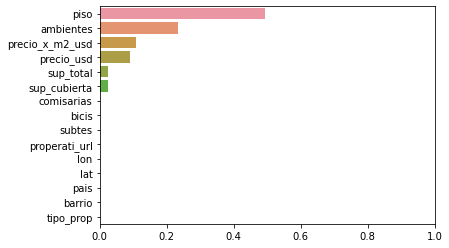

In [59]:
miss = data.isnull().sum(axis = 0) / data.shape[0]
miss = miss.sort_values(ascending = False)

g = sns.barplot(y = miss.index, x = miss)
g.set(xlim = (0,1))

# Análisis Exploratorio

[Text(0.5, 0, 'Subtes a menos de 500 metros'),
 Text(0, 0.5, 'Precio x M2 (USD)')]

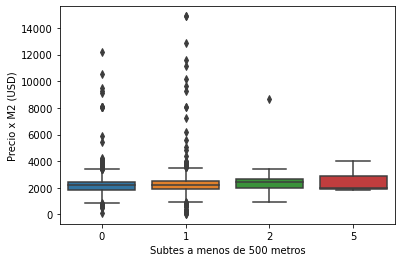

In [399]:
datin = data[((data.barrio == "Flores") | (data.barrio == "Caballito") | (data.barrio == "Parque Chacabuco")) & (data.precio_x_m2_usd < 15000) & (data.tipo_prop != "store")]

a = sns.boxplot(x = 'subtes', y = 'precio_x_m2_usd', data = datin)
a.set(xlabel = "Subtes a menos de 500 metros", ylabel = "Precio x M2 (USD)")

[Text(0.5, 0, 'Distancia a la comisaria más cercana'),
 Text(0, 0.5, 'Precio x M2 (USD)')]

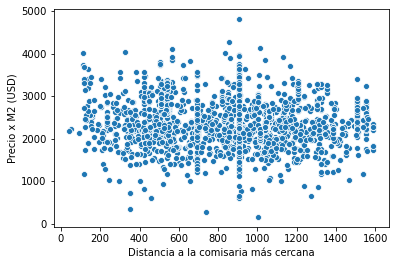

In [400]:
datin = data[(data.precio_x_m2_usd < 5000) & (data.tipo_prop != "store") & (data.barrio == "Caballito") & (data.comisarias < 2000)]

a = sns.scatterplot(x = 'comisarias', y = 'precio_x_m2_usd', data = datin)
a.set(xlabel = "Distancia a la comisaria más cercana", ylabel = "Precio x M2 (USD)")

In [401]:
a = data[data.precio_x_m2_usd < 99999].groupby(['tipo_prop', 'barrio']).median().precio_x_m2_usd

PH = a.loc['PH'].sort_values(ascending = False)[:5]
PH.name = "PH"

apart = a.loc['apartment'].sort_values(ascending = False)[:5]
apart.name = "Dpto"

store = a.loc['store'].sort_values(ascending = False)[:5]
store.name = "Tienda"

house = a.loc['house'].sort_values(ascending = False)[:5]
house.name = "Casa"

apart

barrio
Boedo            7833.333333
Puerto Madero    6047.065338
Palermo Chico    4425.000000
Las Cañitas      3337.669850
Palermo          3180.000000
Name: Dpto, dtype: float64

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Once'),
  Text(1, 0, 'Recoleta'),
  Text(2, 0, 'Villa Riachuelo'),
  Text(3, 0, 'Las Cañitas'),
  Text(4, 0, 'Palermo Soho')])

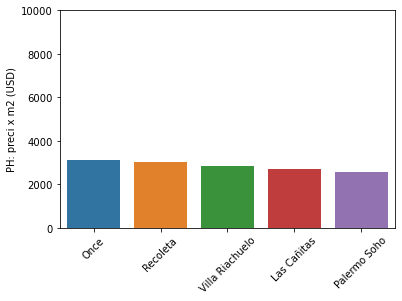

In [402]:
a = sns.barplot(x = list(PH.index)[:5], y = PH)
a.set(ylabel = "PH: preci x m2 (USD)", ylim = (0, 10000))
plt.xticks(rotation = 45)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Boedo'),
  Text(1, 0, 'Puerto Madero'),
  Text(2, 0, 'Palermo Chico'),
  Text(3, 0, 'Las Cañitas'),
  Text(4, 0, 'Palermo')])

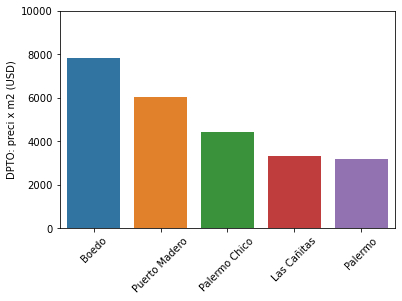

In [403]:
a = sns.barplot(x = list(apart.index)[:5], y = apart)
a.set(ylabel = "DPTO: preci x m2 (USD)", ylim = (0, 10000))
plt.xticks(rotation = 45)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Palermo Chico'),
  Text(1, 0, 'Puerto Madero'),
  Text(2, 0, 'Recoleta'),
  Text(3, 0, 'Palermo'),
  Text(4, 0, 'Belgrano')])

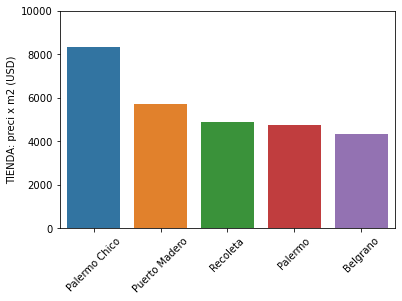

In [404]:
a = sns.barplot(x = list(store.index)[:5], y = store)
a.set(ylabel = "TIENDA: preci x m2 (USD)", ylim = (0, 10000))
plt.xticks(rotation = 45)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Palermo Chico'),
  Text(1, 0, 'Monte Castro'),
  Text(2, 0, 'Puerto Madero'),
  Text(3, 0, 'Las Cañitas'),
  Text(4, 0, 'Barrio Norte')])

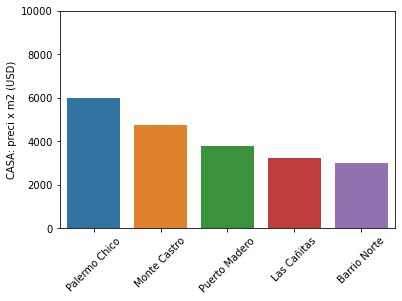

In [405]:
a = sns.barplot(x = list(house.index)[:5], y = house)
a.set(ylabel = "CASA: preci x m2 (USD)", ylim = (0, 10000))
plt.xticks(rotation = 45)

In [428]:
geo_caba = geopandas.read_file("barrios.txt")
geo_caba

,barrio,comuna,perimetro,area,geometry
0,CHACARITA,15,7724.852955,3.115707e+06,"POLYGON ((-58.45282 -34.59599, -58.45366 -34.5..."
1,PATERNAL,15,7087.513295,2.229829e+06,"POLYGON ((-58.46558 -34.59656, -58.46562 -34.5..."
2,VILLA CRESPO,15,8131.857075,3.615978e+06,"POLYGON ((-58.42375 -34.59783, -58.42495 -34.5..."
3,VILLA DEL PARQUE,11,7705.389797,3.399596e+06,"POLYGON ((-58.49461 -34.61487, -58.49479 -34.6..."
4,ALMAGRO,5,8537.901368,4.050752e+06,"POLYGON ((-58.41287 -34.61412, -58.41282 -34.6..."
5,CABALLITO,6,10990.964471,6.851029e+06,"POLYGON ((-58.43061 -34.60705, -58.43056 -34.6..."
6,VILLA SANTA RITA,11,5757.752335,2.153691e+06,"POLYGON ((-58.48192 -34.62429, -58.48274 -34.6..."
7,MONTE CASTRO,10,7361.036418,2.627481e+06,"POLYGON ((-58.50349 -34.62403, -58.50467 -34.6..."
8,VILLA REAL,10,5070.965652,1.334146e+06,"POLYGON ((-58.52512 -34.61400, -58.52511 -34.6..."
9,FLORES,7,15772.439510,8.590784e+06,"POLYGON ((-58.46041 -34.65680, -58.46090 -34.6..."


<AxesSubplot:>

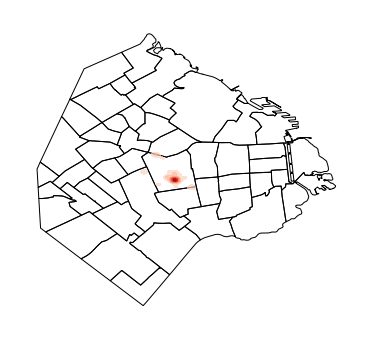

In [407]:
datin2 = geopandas.GeoDataFrame(datin, geometry=geopandas.points_from_xy(datin.lon, datin.lat))
datin2

ax = geo.kdeplot(datin2, shade = True, alpha = 0.7, cmap = 'Reds')
geo.polyplot(geo_caba, ax = ax)

<AxesSubplot:>

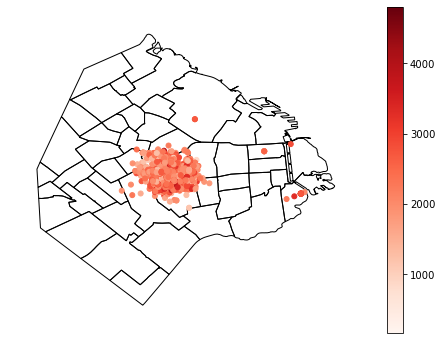

In [408]:
ax = geo.pointplot(datin2[datin2.precio_x_m2_usd < 12500], hue = 'precio_x_m2_usd', legend = True, cmap = 'Reds')
geo.polyplot(geo_caba, ax = ax)

<AxesSubplot:>

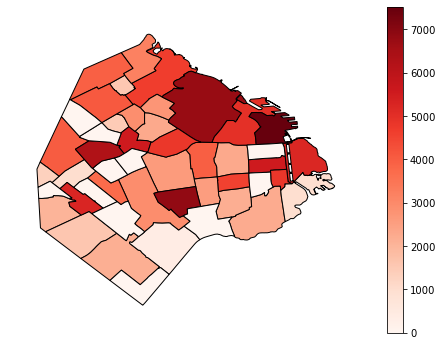

In [409]:
datin = data[data.tipo_prop == "store"].groupby('barrio').mean().precio_x_m2_usd.fillna(0)
datin.index = datin.index.str.lower()
datin

geo_caba['barrio'] = geo_caba.barrio.str.lower()

datin2 = pd.merge(datin, geo_caba, left_on= 'barrio', right_on= 'barrio', how = 'right').fillna(0)

datin2 = geopandas.GeoDataFrame(datin2)

geo.choropleth(datin2, hue = datin2['precio_x_m2_usd'],legend = True, cmap = 'Reds')

<AxesSubplot:>

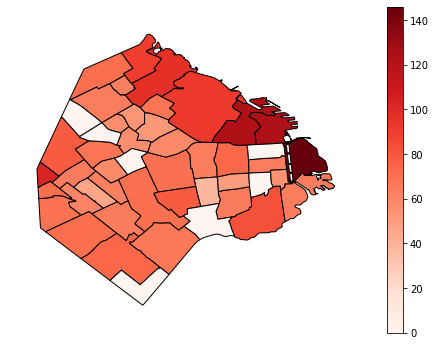

In [410]:
datin = data[data.tipo_prop == "apartment"].groupby('barrio').mean().sup_total.fillna(0)
datin.index = datin.index.str.lower()
datin

geo_caba['barrio'] = geo_caba.barrio.str.lower()

datin2 = pd.merge(datin, geo_caba, left_on= 'barrio', right_on= 'barrio', how = 'right').fillna(0)

datin2 = geopandas.GeoDataFrame(datin2)

geo.choropleth(datin2, hue = datin2['sup_total'],legend = True, cmap = 'Reds')

# URL

In [62]:
i = 150

print(data.properati_url.iloc[i])

http://www.properati.com.ar/15f6f_venta_departamento_villa-devoto_balcon_baulera_suite_jardin_lavadero_patio_toilette_vista_lujoso_dependencias_electrogeno_garage_doble-circulacion_lincoln-propiedades_c08


In [71]:
patron = "http:\/\/www.properati.com.ar\/\S{1,5}_venta_\w+_"
patron = re.compile(patron)

data['properati_url_clean'] = data.properati_url.str.replace(patron, "")
data.properati_url_clean

a = data.properati_url_clean.str.split("_")

b = []
for x in a:
    for i in x:
        b.append(i)

b = pd.Series(b)

b = b.value_counts(ascending = False)

# sns.barplot(y = b.index, x = b)

variables = b.index

b[40:80]

Index(['quincho', 'puerto-madero', 'san-cristobal', 'korn-propiedades', 'gex',
       'baigun-operaciones-inmobiliarias', 'gi7', 'palermo-hollywood',
       'soldati-propiedades', 'villa-del-parque', 'di-mitrio-inmobiliaria',
       'gjr', 'gik', 'electrogeno', 'villa-luro', 'villa-devoto',
       'situar-propiedades', 'palermo-soho', 'le-bleu', 'amoblado', '1600',
       'desarrollos-financiados', 'parque-patricios', 'migliorisi-propiedades',
       'giv', 're-max-premium', 'bs-as-g-b-a-zona-norte', 'fk5',
       'norde-propiedades', 'gfh', 'gi2', 'cobo-av-', 'bienvende-amelia-claro',
       'grupo-galactica', 'caian-negocis-inmobiliarios',
       'emprendimientos-financiados', 'm-m-propiedades', 'yankel-group',
       'palermo-chico', 'capital-brokers'],
      dtype='object')

In [64]:
urls = pd.DataFrame(index = data.index)

for x in variables:
    i = x.replace("-", "_")
    a = "(?P<" + i + ">" + x + ")"
    
    reg = re.compile(a, flags= re.IGNORECASE)
    
    url = data.properati_url_clean.str.extract(reg).applymap(lambda x: 0 if x is np.NaN else 1)
    
    urls = pd.merge(urls, url, right_index= True, left_index= True)

In [65]:
data2 = pd.merge(data, urls, left_index= True, right_index= True, how = "outer")
data2.head()

,tipo_prop,barrio,pais,lat,lon,precio_usd,piso,properati_url,ambientes,sup_total,...,villa_crespo,hidromasaje,san_telmo,vista,sauna,losa_radiante,capital_federal,impecable,interwin,doble_circulacion
0,PH,Mataderos,Argentina,-34.661824,-58.508839,62000.0,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,2.0,55.0,...,0,0,0,0,0,0,0,0,0,0
1,apartment,Mataderos,Argentina,-34.652262,-58.522982,72000.0,3.0,http://www.properati.com.ar/15bod_venta_depart...,2.0,55.0,...,0,0,0,0,0,0,0,0,0,0
2,PH,Liniers,Argentina,-34.647797,-58.516424,95000.0,0.0,http://www.properati.com.ar/15boh_venta_ph_lin...,3.0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,apartment,Belgrano,Argentina,-34.559873,-58.443362,138000.0,NaN,http://www.properati.com.ar/15bot_venta_depart...,1.0,45.0,...,0,0,0,0,0,0,0,0,0,0
4,apartment,Belgrano,Argentina,-34.559873,-58.443362,195000.0,NaN,http://www.properati.com.ar/15bou_venta_depart...,NaN,65.0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
data2.to_csv("salida_desafio_1.csv")